In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
def plot_AUC(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

In [3]:
cols = ["日产量", "日活动量", "日反刍量", "泌乳天数", "泌乳期", "新增疾病类型"]
data = pd.read_csv("../data/sample.csv", usecols=cols)

#### 查看疾病分类

In [4]:
data["新增疾病类型"].value_counts()

乳房疾病      915
生殖系统      542
自定义疾病     386
消化系统       97
营养代谢系统     81
传染病        20
应激与过敏      16
神经系统        8
四肢疾病        6
泌尿系统        3
Name: 新增疾病类型, dtype: int64

In [5]:
del_dis = ["传染病", "应激与过敏", "神经系统", "四肢疾病", "泌尿系统"]
for dis in del_dis:
    data.drop(data[data["新增疾病类型"] == dis.strip()].index, axis=0, inplace=True)

In [6]:
data["新增疾病类型"].value_counts()

乳房疾病      915
生殖系统      542
自定义疾病     386
消化系统       97
营养代谢系统     81
Name: 新增疾病类型, dtype: int64

In [7]:
# 把空值转化为 0
data["新增疾病类型"].fillna(0, inplace=True)

In [8]:
# 把非空值转化为 1
data["新增疾病类型"] = data["新增疾病类型"].map(lambda x: 1 if x else 0)

In [9]:
# 查看空准确率
data["新增疾病类型"].value_counts()

0    190144
1      2021
Name: 新增疾病类型, dtype: int64

In [10]:
data["新增疾病类型"].value_counts(normalize=True)

0    0.989483
1    0.010517
Name: 新增疾病类型, dtype: float64

In [11]:
data_0 = data[data["新增疾病类型"] == 0]

In [12]:
data_1 = data[data["新增疾病类型"] == 1]

In [13]:
index_0 = np.random.choice(data_0.shape[0], 3000)

In [14]:
data_0.iloc[index_0]

,日产量,日活动量,日反刍量,泌乳天数,泌乳期,新增疾病类型
178290,34.816002,474.0,543.0,72,1,0
145859,19.399000,461.0,497.0,310,1,0
103757,50.292000,473.0,591.0,42,2,0
62766,63.022999,566.0,572.0,74,3,0
58191,18.705000,491.0,546.0,285,3,0
...,...,...,...,...,...,...
187309,30.879999,413.0,535.0,80,1,0
188593,32.169998,522.0,628.0,24,1,0
181162,34.194000,460.0,422.0,95,1,0
23765,33.173000,500.0,575.0,192,5,0


### 训练模型

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
data.dropna(inplace=True)
# y=data['新增疾病类型']
y = data[["新增疾病类型"]]
X = data.drop("新增疾病类型", axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report

In [19]:
def make_brf_modle(X_train, y_train, X_test, y_test):
    BRF = BalancedRandomForestClassifier(
        n_estimators=5,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=2,
        min_weight_fraction_leaf=0,
        max_features="auto",
        min_impurity_decrease=0,
        bootstrap=True,
        oob_score=False,
        sampling_strategy="auto",
        replacement=False,
        n_jobs=1,
        random_state=42,
        verbose=2,
        warm_start=False,
        class_weight=None,
    )
    BRF.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,BRF.predict(X_test))}")

    return BRF

In [20]:
make_brf_modle(X_train, y_train, X_test, y_test)

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
score:              precision    recall  f1-score   support

           0       1.00      0.82      0.90     37998
           1       0.05      0.83      0.09       418

    accuracy                           0.82     38416
   macro avg       0.52      0.83      0.50     38416
weighted avg       0.99      0.82      0.89     38416



C:\Users\10069\AppData\Local\Temp\ipykernel_25768\884691051.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  BRF.fit(X_train, y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
d:\Program\Python3.10\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
d:\Program\Python3.10\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
d:\Program\Python3.10\lib\site-packages\sklearn\tree\_classes.py:269: Fu

BalancedRandomForestClassifier(max_features='auto', min_impurity_decrease=0,
                               min_samples_leaf=2, min_weight_fraction_leaf=0,
                               n_estimators=5, n_jobs=1, random_state=42,
                               verbose=2)

#### 标准化

In [21]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(pd.DataFrame(X_test))

In [22]:
make_brf_modle(X_train_std, y_train, X_test_std, y_test)

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
score:              precision    recall  f1-score   support

           0       1.00      0.81      0.90     37998
           1       0.05      0.83      0.09       418

    accuracy                           0.81     38416
   macro avg       0.52      0.82      0.49     38416
weighted avg       0.99      0.81      0.89     38416



C:\Users\10069\AppData\Local\Temp\ipykernel_25768\884691051.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  BRF.fit(X_train, y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
d:\Program\Python3.10\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
d:\Program\Python3.10\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
d:\Program\Python3.10\lib\site-packages\sklearn\tree\_classes.py:269: Fu

BalancedRandomForestClassifier(max_features='auto', min_impurity_decrease=0,
                               min_samples_leaf=2, min_weight_fraction_leaf=0,
                               n_estimators=5, n_jobs=1, random_state=42,
                               verbose=2)

In [23]:
y_train

,新增疾病类型
101674,0
135829,0
75543,0
104568,0
133256,0
...,...
119998,0
103809,0
132051,0
146986,0


### BalanceBaggingClassifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier


def make_bbc_model(X_train, y_train, X_test, y_test):
    bbc = BalancedBaggingClassifier(
        estimator=DecisionTreeClassifier(),
        sampling_strategy="auto",
        replacement=True,
        random_state=42,
    )
    bbc.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,bbc.predict(X_test))}")
    return bbc

In [25]:
bbc = make_bbc_model(X_train, y_train, X_test, y_test)

d:\Program\Python3.10\lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:              precision    recall  f1-score   support

           0       1.00      0.91      0.95     37998
           1       0.08      0.78      0.15       418

    accuracy                           0.91     38416
   macro avg       0.54      0.84      0.55     38416
weighted avg       0.99      0.91      0.94     38416



#### 绘制混淆矩阵

In [26]:
# confusion_matrix(X_test, y_test)

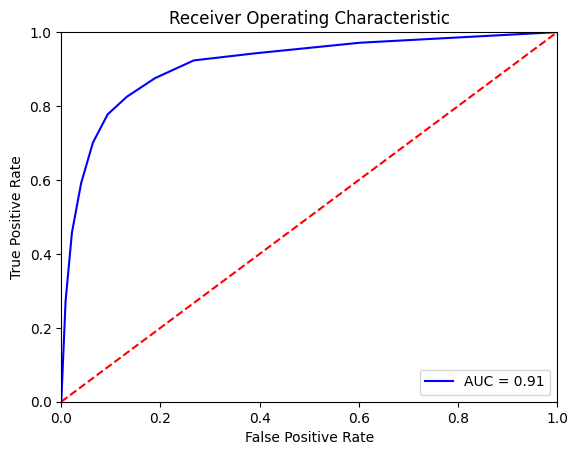

In [27]:
plot_AUC(bbc, X_test, y_test)

### XGB

In [28]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [29]:
# scale_pos_weight=1000,


def make_xgb_model(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(
        eval_metrics=["logloss", "auc", "error"],
        learning_rate=0.07,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        scale_pos_weight=1000,
        nthread=4,
        seed=42,
    )
    xgb.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,xgb.predict(X_test))}")
    return xgb

In [30]:
xgb = make_xgb_model(X_train, y_train, X_test, y_test)

[12:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "eval_metrics" } are not used.

score:              precision    recall  f1-score   support

           0       1.00      0.92      0.95     37998
           1       0.09      0.75      0.16       418

    accuracy                           0.91     38416
   macro avg       0.54      0.83      0.56     38416
weighted avg       0.99      0.91      0.95     38416



In [31]:
# confusion_matrix(X_test, y_test)

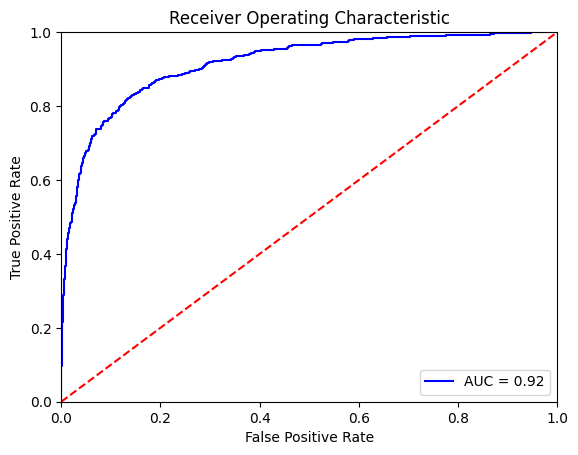

In [32]:
plot_AUC(xgb, X_test, y_test)

### 疾病分类模型

In [33]:
cols = ["日产量", "日活动量", "日反刍量", "泌乳天数", "泌乳期", "新增疾病类型"]
data2 = pd.read_csv("../data/sample.csv", usecols=cols)

In [34]:
data2_notnull = data2[data2["新增疾病类型"].notnull()]

In [35]:
data2_notnull

,日产量,日活动量,日反刍量,泌乳天数,泌乳期,新增疾病类型
775,2.489000,531.0,446.0,445,5,乳房疾病
878,1.671000,620.0,533.0,444,4,乳房疾病
952,48.643002,505.0,487.0,35,5,乳房疾病
953,22.277000,510.0,430.0,36,5,乳房疾病
954,16.101999,496.0,373.0,37,5,乳房疾病
...,...,...,...,...,...,...
190625,39.389999,539.0,563.0,24,1,生殖系统
190626,34.597000,536.0,657.0,25,1,生殖系统
190627,35.306999,513.0,638.0,26,1,生殖系统
190628,40.227001,502.0,659.0,27,1,生殖系统


In [36]:
del_dis = ["传染病", "应激与过敏", "神经系统", "四肢疾病", "泌尿系统"]
for dis in del_dis:
    data2_notnull.drop(
        data2_notnull[data2_notnull["新增疾病类型"] == dis.strip()].index,
        axis=0,
        inplace=True,
    )

C:\Users\10069\AppData\Local\Temp\ipykernel_25768\2087708450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_notnull.drop(


In [37]:
data2_notnull["新增疾病类型"].value_counts()

乳房疾病      915
生殖系统      542
自定义疾病     386
消化系统       97
营养代谢系统     81
Name: 新增疾病类型, dtype: int64

In [38]:
dis_type = enumerate(data2_notnull["新增疾病类型"].unique())
dis_type_dict = dict(dis_type)
dt = {v: k for k, v in dis_type_dict.items()}

In [39]:
dt

{'乳房疾病': 0, '消化系统': 1, '自定义疾病': 2, '生殖系统': 3, '营养代谢系统': 4}

In [40]:
data2_notnull["类型"] = data2_notnull["新增疾病类型"].map(dt)

C:\Users\10069\AppData\Local\Temp\ipykernel_25768\2143366885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_notnull["类型"] = data2_notnull["新增疾病类型"].map(dt)


In [41]:
data_dis = data2_notnull.drop(columns="新增疾病类型")

In [42]:
data_dis["类型"].value_counts()

0    915
3    542
2    386
1     97
4     81
Name: 类型, dtype: int64